In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

XTREME has 183 configurations


In [5]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [6]:
from datasets import load_dataset

ds_en = load_dataset("xtreme", name="PAN-X.en")

train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
for split in ds_en:
    print(ds_en[split].num_rows)

20000
10000
10000


In [8]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
panx_ch = defaultdict(DatasetDict)
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict, {})

In [9]:
for lang, frac in zip(langs, fracs):
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in ds:
        # print(range(int(frac * ds[split].num_rows)))
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows)))
        )

train-00000-of-00001.parquet:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/590k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/588k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/837k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/423k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/932k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/459k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/464k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
            ["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


#### by design, we have more examples in German than all other languages combined

In [11]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [12]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [13]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [14]:
def create_tag_names(batch):
    return {
        "ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]
    }

In [15]:
panx_de = panx_ch["de"].map(create_tag_names)

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [16]:
de_example = panx_de["train"][0] 
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], 
             ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [17]:
from collections import Counter

split2freqs = defaultdict(Counter)
split2freqs

defaultdict(collections.Counter, {})

In [18]:
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag in row:
                if tag.startswith("B"):
                    tag_type = tag.split("-")[1]
                    split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [19]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [20]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [21]:
bert_tokens, xlmr_tokens

(['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]'],
 ['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>'])

## the tokenizer pipeline
#### Normalization Pretokenization Tokenizer model Postprocessing

## Transformers for Sequence Classification

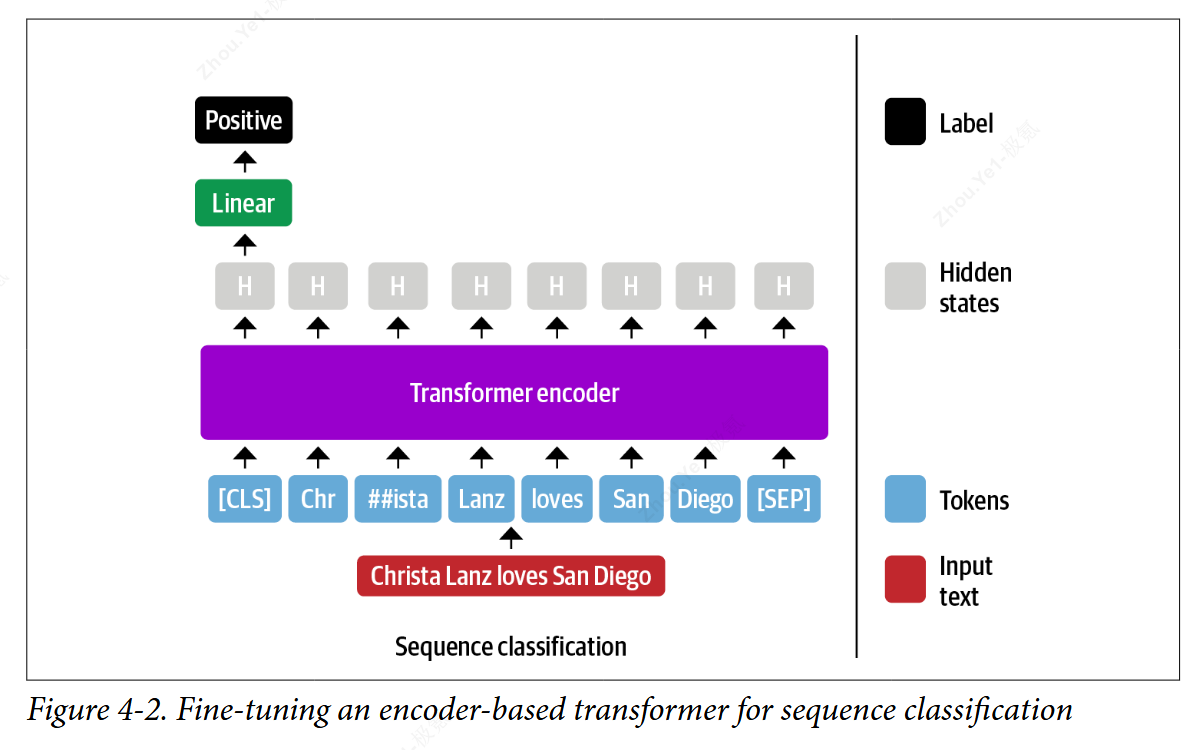

## Transformers for Named Entity Recognition

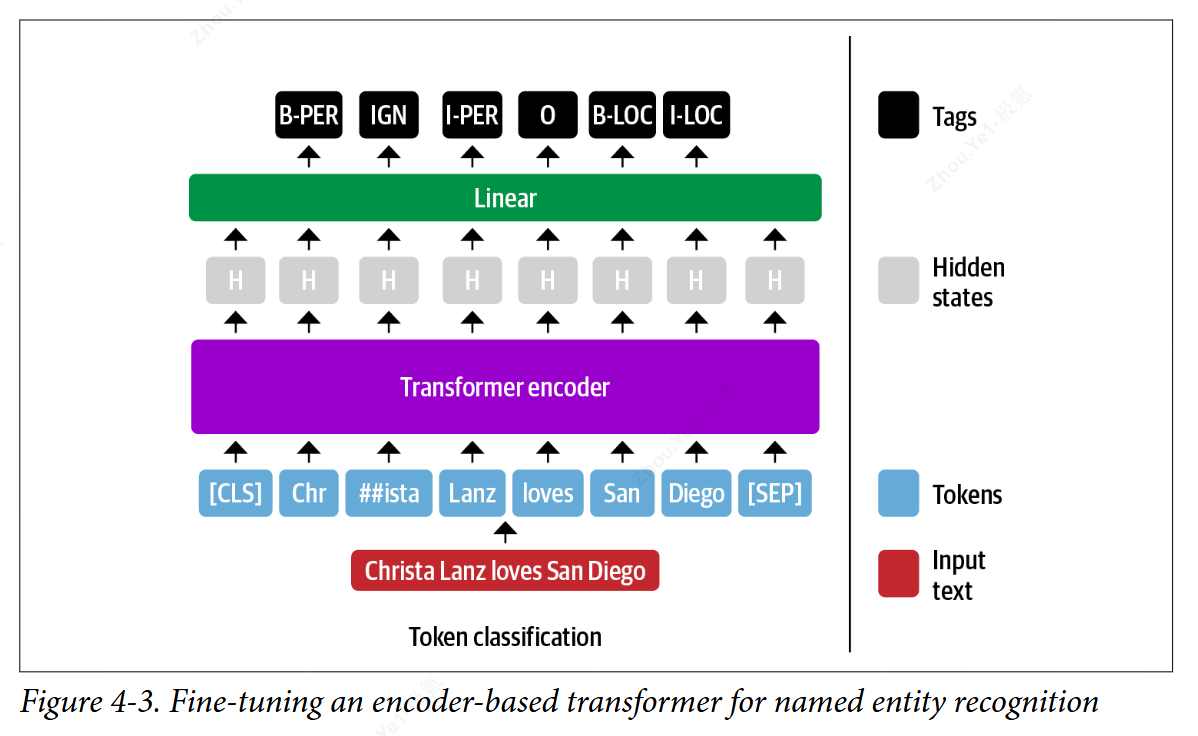

In [22]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [23]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representation
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                              token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                    hidden_states=outputs.hidden_states,
                                    attentions=outputs.attentions)

In [24]:
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [25]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [26]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [27]:
tag2index

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6}

In [28]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                        num_labels=tags.num_classes,
                                        id2label=index2tag, label2id=tag2index)

In [29]:
xlmr_model_name

'xlm-roberta-base'

In [30]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
XLMRobertaForTokenClassification

__main__.XLMRobertaForTokenClassification

In [32]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [33]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [34]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,I-PER


In [35]:
print(predictions[0].cpu().numpy())

[3 1 1 1 1 1 1 1 1 2]


In [36]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=-1)
    # Convert into DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [37]:
tag_text(text, tags, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,B-ORG,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,B-PER,I-PER


In [38]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [39]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokenized_input

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23, 122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [40]:
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [41]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [42]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
1,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
2,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
3,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [43]:
## for batch operation, tokenized_input is a list(list), its need to use enumerate(tags) and tokenized_input.word_ids(batch_index=idx) to take word_ids for each example 
def tokenize_and_align_labels(examples):
    tokenized_input = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    tags = examples["ner_tags"]
    # tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
    labels = []
    for idx, label in enumerate(tags):
        word_ids = tokenized_input.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_input["labels"] = labels
    return tokenized_input

In [44]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                     remove_columns=['langs', 'ner_tags', 'tokens'])

In [45]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [46]:
panx_de_encoded["train"][0]

{'input_ids': [0,
  70101,
  176581,
  19,
  142,
  122,
  2290,
  708,
  1505,
  18363,
  18,
  23,
  122,
  127474,
  15439,
  13787,
  14,
  15263,
  18917,
  663,
  6947,
  19,
  6,
  5,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  0,
  0,
  -100,
  0,
  0,
  5,
  -100,
  -100,
  6,
  -100,
  0,
  0,
  5,
  -100,
  5,
  -100,
  -100,
  -100,
  6,
  -100,
  -100,
  0,
  -100,
  -100]}

In [47]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=00ee4e82508752ffc3b963a492432a921bee1dce1da27e78381d58493ac66ae5
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [48]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "B-MISC", "O"]] 
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"], ["B-PER", "I-PER", "B-PER", "O"]] 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.50      1.00      0.67         1

   micro avg       0.33      0.33      0.33         3
   macro avg       0.25      0.50      0.33         3
weighted avg       0.17      0.33      0.22         3



In [49]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

In [97]:
from transformers import TrainingArguments  
num_epochs = 3 
batch_size = 24 
logging_steps = len(panx_de_encoded["train"]) // batch_size 
model_name = f"{xlmr_model_name}-finetuned-panx-de" 
training_args = TrainingArguments(output_dir=model_name, 
                                  log_level="info", 
                                  num_train_epochs=num_epochs, 
                                  per_device_train_batch_size=batch_size, 
                                  per_device_eval_batch_size=batch_size, 
                                  eval_strategy="epoch", 
                                  save_steps=1e6, 
                                  weight_decay=0.01, 
                                  disable_tqdm=False, 
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  no_cuda=False,
                                  save_total_limit=0,
                                  report_to="none")

PyTorch: setting up devices


In [51]:
# from huggingface_hub import notebook_login

# notebook_login()

In [52]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                      eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [53]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [54]:
def model_init():
    return (XLMRobertaForTokenClassification
           .from_pretrained(xlmr_model_name, config=xlmr_config)
           .to(device))

In [55]:
from transformers import Trainer

trainer = Trainer(model_init=model_init, 
                  args=training_args,
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

<ipython-input-55-fef469143346>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

In [56]:
trainer.train()
# trainer.push_to_hub(commit_message="Training completed!")

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobe

Epoch,Training Loss,Validation Loss,F1
1,0.260500,0.152440,0.828439
2,0.127500,0.135125,0.853524
3,0.079600,0.135612,0.857856



***** Running Evaluation *****
  Num examples = 6290
  Batch size = 24

***** Running Evaluation *****
  Num examples = 6290
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-de/checkpoint-1575
Configuration saved in xlm-roberta-base-finetuned-panx-de/checkpoint-1575/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-de/checkpoint-1575/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-1575/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-1575/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 6290
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1575, training_loss=0.1557654791218894, metrics={'train_runtime': 281.4398, 'train_samples_per_second': 134.096, 'train_steps_per_second': 5.596, 'total_flos': 862324400720376.0, 'train_loss': 0.1557654791218894, 'epoch': 3.0})

In [57]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


In [58]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Prediction class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
                        labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [59]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()
df.head(1)

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[-100, 3, -100, 4, 4, 4, -100]","[0.0, 0.01079293, 0.0, 0.009963186, 0.00786103...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [60]:
index2tag[-100] = "IGN"

In [61]:
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x]
)
df["loss"] = df.apply(
    lambda x: x["loss"][:len(x["input_ids"])], axis=1
)
df["predicted_label"] = df.apply(
    lambda x: x["predicted_label"][:len(x["input_ids"])], axis=1
)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.01079293, 0.0, 0.009963186, 0.00786103...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [62]:
df['loss'][0]

array([0.        , 0.01079293, 0.        , 0.00996319, 0.00786103,
       0.00924402, 0.        ], dtype=float32)

In [63]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.34,B-LOC,▁Luz
1,10,1,I-ORG,1.22,I-LOC,▁a


In [64]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁'',▁),▁A
count,6066,1388,989,808,163,1171,246,2898,246,125
mean,0.04,0.09,0.12,0.14,0.6,0.07,0.33,0.03,0.3,0.44
sum,232.87,127.26,121.88,112.93,97.17,84.87,80.03,75.26,73.15,55.06


In [65]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6
labels,I-LOC,B-ORG,I-ORG,B-LOC,B-PER,I-PER,O
count,1462,2683,3820,3172,2893,4139,43648
mean,0.63,0.6,0.48,0.35,0.25,0.19,0.03
sum,920.82,1608.41,1836.22,1101.37,720.26,773.25,1373.75


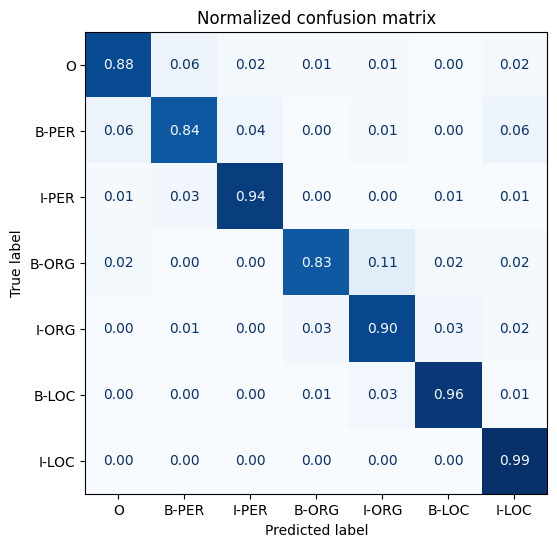

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                    tags.names)

In [67]:
df

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.01079293, 0.0, 0.009963186, 0.00786103...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"
1,"[0, 56530, 25216, 30121, 152385, 19229, 83982,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, IGN, IGN, IGN, IGN, B-ORG, IGN, IGN, ...","[0.0, 0.00021121655, 0.0, 0.0, 0.0, 0.0, 1.339...","[I-ORG, O, O, O, O, O, B-LOC, I-LOC, I-LOC, I-...","[<s>, ▁WE, ITE, RL, EIT, UNG, ▁Luz, ky, j, ▁a,..."
2,"[0, 159093, 165, 38506, 122, 153080, 29088, 57...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, O, B-ORG, IGN, IGN, O, IGN, O, ...","[0.0, 0.0001504308, 0.00010072678, 0.000108355...","[O, O, O, O, O, B-ORG, I-ORG, I-ORG, O, I-ORG,...","[<s>, ▁entdeckt, ▁und, ▁gehört, ▁der, ▁Spek, t..."
3,"[0, 16459, 242, 5106, 6, 198715, 5106, 242, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, O, B-LOC, IGN, O, O, IGN]","[0.0, 0.00023457636, 0.00013195598, 0.00016342...","[B-LOC, O, O, O, B-LOC, I-LOC, O, O, B-LOC]","[<s>, ▁**, ▁', ▁'', ▁, Bretagne, ▁'', ▁', </s>]"
4,"[0, 11022, 2315, 7418, 1079, 8186, 57242, 97, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, IGN, O, O, O, B-ORG...","[0.0, 0.00010168035, 0.00010823618, 0.00013481...","[O, O, O, O, O, O, O, O, O, O, O, O, B-ORG, I-...","[<s>, ▁Nach, ▁einem, ▁Jahr, ▁bei, ▁diesem, ▁Ve..."
...,...,...,...,...,...,...
6285,"[0, 10333, 599, 7418, 4180, 72, 3700, 542, 900...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG...","[0.0, 0.00010108437, 9.548208e-05, 0.000129214...","[O, O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, ...","[<s>, ▁Für, ▁ein, ▁Jahr, ▁wurde, ▁er, ▁dann, ▁..."
6286,"[0, 15497, 7, 91243, 15, 23924, 96220, 1388, 2]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, B-LOC, IGN, IGN, I-LOC, I-LOC, I-LOC, I-...","[0.0, 0.016404402, 0.0, 0.0, 0.012788193, 0.01...","[I-LOC, B-LOC, I-LOC, I-LOC, I-LOC, I-LOC, I-L...","[<s>, ▁Green, s, boro, ▁(, ▁North, ▁Carolina, ..."
6287,"[0, 1858, 566, 12241, 729, 4598, 89841, 68125,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, IGN, O, IGN, IGN, O, O, O, I...","[0.0, 0.00010108437, 9.822363e-05, 0.000106448...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[<s>, ▁Das, ▁im, ▁Jahre, ▁17, 60, ▁fertig, ges..."
6288,"[0, 132005, 11399, 7, 84974, 168, 34525, 84247...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, O, IGN, O, O, B-LOC, I-LOC, O, O, IGN...","[0.0, 0.00021789085, 0.0015550675, 0.0, 0.0001...","[O, O, O, O, O, O, B-ORG, I-ORG, O, O, O, O]","[<s>, ▁Beide, ▁Team, s, ▁gehören, ▁den, ▁Origi..."


In [68]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

In [69]:
def  get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                              "preds": preds, "losses": losses}).T
        yield df_tmp

In [70]:
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,2.79,0.00,0.00,0.00,10.81,10.75,7.80,9.54,10.61,0.00,10.31,10.45,0.00,10.08,9.97,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.91,0.00,0.00,7.35,9.46,9.27,7.01,0.00,6.80,8.93,7.95,7.44,6.47,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.27,6.19,6.02,0.00,5.94,0.00,5.78,0.00,5.62,5.07,5.45,5.07,5.23,5.47,0.00


In [71]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.04,0.00,0.00,0.03,0.04,0.00,0.03,0.00


In [72]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [73]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")


***** Running Prediction *****
  Num examples = 6290
  Batch size = 24


F1-score of [de] model on [de] dataset: 0.865


In [74]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [75]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [76]:
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]


***** Running Prediction *****
  Num examples = 2290
  Batch size = 24


F1-score of [de] model on [fr] dataset: 0.708


In [77]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]


***** Running Prediction *****
  Num examples = 840
  Batch size = 24


F1-score of [de] model on [it] dataset: 0.671


In [78]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]


***** Running Prediction *****
  Num examples = 590
  Batch size = 24


F1-score of [de] model on [en] dataset: 0.591


In [79]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, 
                      args=training_args,
                      data_collator=data_collator, 
                      compute_metrics=compute_metrics,
                      train_dataset=train_ds,
                      eval_dataset=valid_ds,
                      tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]}
    )

In [80]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

In [81]:
panx_fr_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2290
    })
})

In [82]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,1.622100,1.285680,0.029835
2,1.169600,0.972795,0.257448
3,0.950100,0.871889,0.422144



***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-de/checkpoint-33
Configuration saved in xlm-roberta-base-finetuned-panx-de/checkpoint-33/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-de/checkpoint-33/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-33/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-33/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)



***** Running Prediction *****
  Num examples = 2290
  Batch size = 24


,num_samples,f1_score
0,250,0.422042


In [83]:
for num_samples in [500, 1000, 2000]:
    metrics_df = pd.concat(
       [metrics_df, train_on_subset(panx_fr_encoded, num_samples)], ignore_index=True
    )

<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,1.401600,0.985518,0.384463
2,0.811200,0.625474,0.591213
3,0.535500,0.552314,0.660586



***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-de/checkpoint-63
Configuration saved in xlm-roberta-base-finetuned-panx-de/checkpoint-63/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-de/checkpoint-63/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-63/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-63/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)



***** Running Prediction *****
  Num examples = 2290
  Batch size = 24


<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,1.041900,0.511733,0.672139
2,0.456300,0.425652,0.723190
3,0.295900,0.383794,0.766163



***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-de/checkpoint-126
Configuration saved in xlm-roberta-base-finetuned-panx-de/checkpoint-126/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-de/checkpoint-126/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-126/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-126/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)



***** Running Prediction *****
  Num examples = 2290
  Batch size = 24


<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,0.761500,0.449620,0.703272
2,0.326300,0.329413,0.769688
3,0.211200,0.335592,0.797872



***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-de/checkpoint-252
Configuration saved in xlm-roberta-base-finetuned-panx-de/checkpoint-252/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-de/checkpoint-252/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-252/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de/checkpoint-252/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)



***** Running Prediction *****
  Num examples = 2290
  Batch size = 24


<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [84]:
metrics_df

,num_samples,f1_score
0,250,0.422042
1,500,0.672044
2,1000,0.768335
3,2000,0.799810


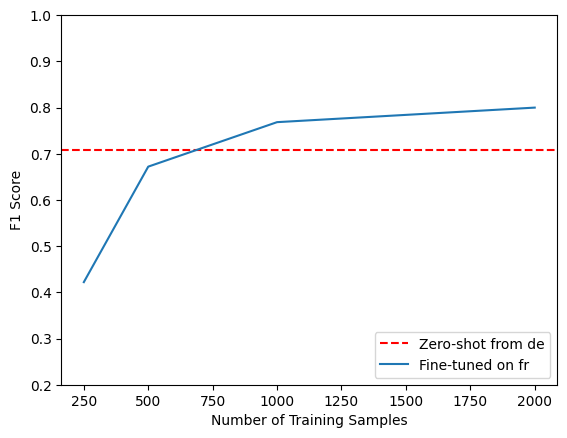

In [89]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0.2, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

## fine-tuning on multiple languages at once

In [93]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]
        ).shuffle(seed=42)
    return multi_corpus

panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [101]:
import os
import shutil

# 删除不必要的目录
shutil.rmtree("/kaggle/working/xlm-roberta-base-finetuned-panx-de-fr", ignore_errors=True)

In [98]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size 
training_args.push_to_hub = True 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"  
trainer = Trainer(model_init=model_init, 
                  args=training_args, 
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics, 
                  tokenizer=xlmr_tokenizer, 
                  train_dataset=panx_de_fr_encoded["train"], 
                  eval_dataset=panx_de_fr_encoded["validation"])  
trainer.train() 
trainer.push_to_hub(commit_message="Training completed!")

<ipython-input-98-ac23bc0c50d7>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,0.279300,0.180192,0.822210
2,0.145900,0.160518,0.850177
3,0.094100,0.163594,0.858574



***** Running Evaluation *****
  Num examples = 8580
  Batch size = 24

***** Running Evaluation *****
  Num examples = 8580
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-de-fr/checkpoint-2145
Configuration saved in xlm-roberta-base-finetuned-panx-de-fr/checkpoint-2145/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-de-fr/checkpoint-2145/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de-fr/checkpoint-2145/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de-fr/checkpoint-2145/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-panx-de-fr/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-de-fr/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 8580
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)


Waiting for the current checkpoint pu

CommitInfo(commit_url='https://huggingface.co/uohzey/xlm-roberta-base-finetuned-panx-de-fr/commit/c3eb4916ac7508af9a078db89ad09aa0b8ba2d49', commit_message='Training completed!', commit_description='', oid='c3eb4916ac7508af9a078db89ad09aa0b8ba2d49', pr_url=None, repo_url=RepoUrl('https://huggingface.co/uohzey/xlm-roberta-base-finetuned-panx-de-fr', endpoint='https://huggingface.co', repo_type='model', repo_id='uohzey/xlm-roberta-base-finetuned-panx-de-fr'), pr_revision=None, pr_num=None)

In [99]:
for lang in langs: 
    f1 = evaluate_lang_performance(lang, trainer) 
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]


***** Running Prediction *****
  Num examples = 6290
  Batch size = 24



***** Running Prediction *****
  Num examples = 2290
  Batch size = 24


F1-score of [de-fr] model on [de] dataset: 0.867



***** Running Prediction *****
  Num examples = 840
  Batch size = 24


F1-score of [de-fr] model on [fr] dataset: 0.862



***** Running Prediction *****
  Num examples = 590
  Batch size = 24


F1-score of [de-fr] model on [it] dataset: 0.793


F1-score of [de-fr] model on [en] dataset: 0.664


In [100]:
corpora = [panx_de_encoded]  
# Exclude German from iteration 
for lang in langs[1:]: 
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}" 
    # Fine-tune on monolingual corpus  
    ds_encoded = encode_panx_dataset(panx_ch[lang]) 
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows) 
    # Collect F1-scores in common dict  
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate 
    corpora.append(ds_encoded)

<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,0.542300,0.304516,0.790338
2,0.256800,0.268141,0.833277
3,0.172200,0.273404,0.845350



***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-fr/checkpoint-573
Configuration saved in xlm-roberta-base-finetuned-panx-fr/checkpoint-573/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-fr/checkpoint-573/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-fr/checkpoint-573/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-fr/checkpoint-573/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-panx-fr/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-fr/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 2290
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)


Waiting for the current checkpoint push to be finished, this mi

<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,0.709900,0.307227,0.766181
2,0.275300,0.263468,0.789050
3,0.180400,0.257571,0.825854



***** Running Evaluation *****
  Num examples = 840
  Batch size = 24

***** Running Evaluation *****
  Num examples = 840
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-it/checkpoint-210
Configuration saved in xlm-roberta-base-finetuned-panx-it/checkpoint-210/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-it/checkpoint-210/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-it/checkpoint-210/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-it/checkpoint-210/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-panx-it/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-it/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 840
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)


Waiting for the current checkpoint push to be finished, this might

<ipython-input-79-3afac132d580>:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaFo

Epoch,Training Loss,Validation Loss,F1
1,1.026300,0.516600,0.573996
2,0.491500,0.425315,0.668149
3,0.379300,0.389925,0.687743



***** Running Evaluation *****
  Num examples = 590
  Batch size = 24

***** Running Evaluation *****
  Num examples = 590
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-en/checkpoint-150
Configuration saved in xlm-roberta-base-finetuned-panx-en/checkpoint-150/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-en/checkpoint-150/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-en/checkpoint-150/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-en/checkpoint-150/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-panx-en/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-en/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 590
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)


Waiting for the current checkpoint push to be finished, this might

In [104]:
f1_scores

defaultdict(dict,
            {'de': {'de': 0.8650413828050223,
              'fr': 0.7082125603864734,
              'it': 0.6713987473903967,
              'en': 0.5913918390162103},
             'fr': {'fr': 0.8504012841091493},
             'it': {'it': 0.8233766233766233},
             'en': {'en': 0.6770293609671848}})

In [102]:
corpora_encoded = concatenate_splits(corpora)

In [103]:
corpora_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20020
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10010
    })
})

In [105]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size 
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"  
trainer = Trainer(model_init=model_init, 
                  args=training_args, 
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics, 
                  tokenizer=xlmr_tokenizer, 
                  train_dataset=corpora_encoded["train"], 
                  eval_dataset=corpora_encoded["validation"])  
trainer.train() 
trainer.push_to_hub(commit_message="Training completed!")

<ipython-input-105-1d4e92d6f8d0>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model_init=model_init,
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--xlm-roberta-base/snapshots/e73636d4f797dec63c3081bb6ed5c7b0bb3f2089/model.safetensors
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaF

Epoch,Training Loss,Validation Loss,F1
1,0.288500,0.205703,0.803922
2,0.153200,0.167240,0.845610
3,0.097900,0.171828,0.853375



***** Running Evaluation *****
  Num examples = 10010
  Batch size = 24

***** Running Evaluation *****
  Num examples = 10010
  Batch size = 24
Saving model checkpoint to xlm-roberta-base-finetuned-panx-all/checkpoint-2505
Configuration saved in xlm-roberta-base-finetuned-panx-all/checkpoint-2505/config.json
Model weights saved in xlm-roberta-base-finetuned-panx-all/checkpoint-2505/model.safetensors
tokenizer config file saved in xlm-roberta-base-finetuned-panx-all/checkpoint-2505/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-all/checkpoint-2505/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-panx-all/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-panx-all/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 10010
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)


Waiting for the current checkpoint push to be fi

CommitInfo(commit_url='https://huggingface.co/uohzey/xlm-roberta-base-finetuned-panx-all/commit/88123c88d62364628313d0cabdeef05dc85cd9eb', commit_message='Training completed!', commit_description='', oid='88123c88d62364628313d0cabdeef05dc85cd9eb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/uohzey/xlm-roberta-base-finetuned-panx-all', endpoint='https://huggingface.co', repo_type='model', repo_id='uohzey/xlm-roberta-base-finetuned-panx-all'), pr_revision=None, pr_num=None)

In [106]:
for idx, lang in enumerate(langs): 
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])  
    scores_data = {"de": f1_scores["de"], 
                   "each": {lang: f1_scores[lang][lang] for lang in langs}, 
                   "all": f1_scores["all"]} 
f1_scores_df = pd.DataFrame(scores_data).T.round(4) 
f1_scores_df.rename_axis(index="Fine-tune on", 
                         columns="Evaluated on", 
                         inplace=True) 
f1_scores_df


***** Running Prediction *****
  Num examples = 6290
  Batch size = 24



***** Running Prediction *****
  Num examples = 2290
  Batch size = 24



***** Running Prediction *****
  Num examples = 840
  Batch size = 24



***** Running Prediction *****
  Num examples = 590
  Batch size = 24


Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8650,0.7082,0.6714,0.5914
each,0.8650,0.8504,0.8234,0.6770
all,0.8656,0.8692,0.8639,0.7549


#### Multilingual learning can provide significant gains in performance, especially if the low-resource languages for corss-lingual transfer belong to similar language families.
#### It is a good idea to focus attention on cross-lingual transfer  within language families, especially when dealing with different scripts like Japanese/Chinese